In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import fastprogress
import ipywidgets
from matplotlib import pyplot, cm
import numpy
import pymc3
import scipy

import pyrff

### Specify Synthetic Problem

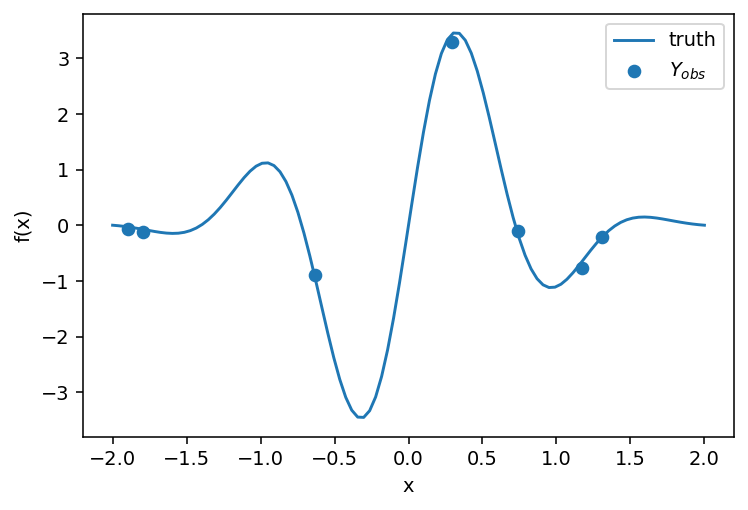

In [3]:
σ_true = 0.1
D = 1
BOUNDS = (-2, 2)

def truth(x):
    y = 3 * numpy.sin((1.5*numpy.pi)*x) + numpy.sin((1*numpy.pi)*x)
    return y * numpy.exp(-x**2)

def observe(x, sigma=σ_true):
    y = truth(x)
    return numpy.random.normal(y[:,0], sigma, size=(len(x),))

# make observations
X = numpy.random.RandomState(202005).uniform(
    low=BOUNDS[0],
    high=BOUNDS[1],
    size=(7,D)
)
Y = observe(X)

# create coordinates for plotting
x_dense = numpy.linspace(*BOUNDS, num=100)[:,None]

# visualize
if D == 1:
    fig, ax = pyplot.subplots(dpi=140)
    ax.plot(x_dense, truth(x_dense), label='truth')
    ax.scatter(X, Y, label='$Y_{obs}$')
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.legend()
    pyplot.show()

### Fit Gaussian Process with `PyMC3`

In [5]:
with pymc3.Model() as pmodel:
    # center the lengthscale prior on half of the space width
    span = numpy.ptp(BOUNDS)
    ls = pymc3.Lognormal('ls', mu=numpy.log(span/2), sd=0.5, shape=span.shape)
    
    # we expect the function to explain most of the variance, so center a prior
    # on the data amplitude
    scaling = pymc3.Lognormal('scaling', mu=numpy.log(numpy.ptp(Y)), sd=0.2)
    # observation noise of around 10 % of the data amplitude sounds realistic..
    sigma = pymc3.Lognormal('sigma', mu=numpy.log(numpy.ptp(Y) / 10), sd=0.2)

    # construct the GP
    # the literature describes RFFs only for 0 mean !!!
    mean_func = pymc3.gp.mean.Zero()
    cov_func = scaling**2 * pymc3.gp.cov.ExpQuad(
        input_dim=D,
        ls=ls
    )
    # the literature only describes RFFs for normally distributed observation noise
    # therefore, we can use gp.Marginal and don't need to use gp.Latent
    gp = pymc3.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    gp.marginal_likelihood('L', X, Y, noise=sigma)
        
with pmodel:
    mp = pymc3.find_MAP()
    
with pmodel:
    idata = arviz.from_pymc3(pymc3.sample(tune=1000, draws=1000))

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:66

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\osthege\AppData\Local\Continuum\miniconda3\en

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 45 seconds.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


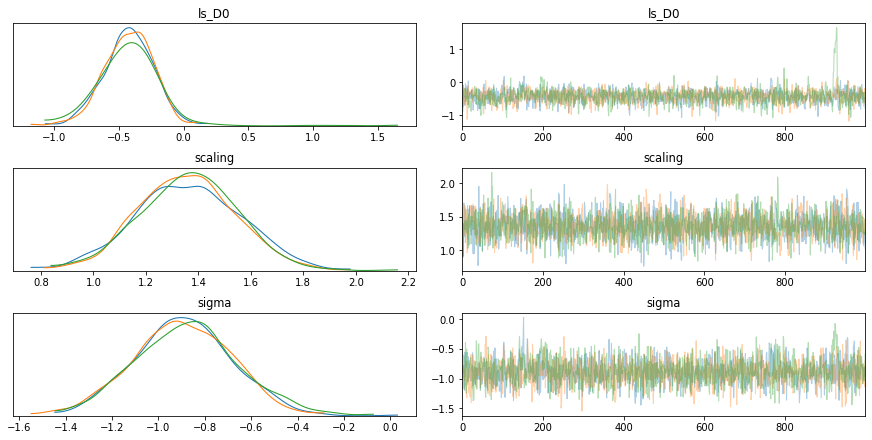

In [6]:
axs = arviz.plot_trace(idata, var_names=['ls', 'scaling', 'sigma'], transform=numpy.log)
for d, axr in zip(range(D), axs):
    dname = f'D{d}'
    for ax in axr:
        ax.set_title(f'ls_{dname}')
pyplot.show()

In [7]:
# add observations, conditioned on slices of x-coordinates to the model
with pmodel:
    gp.conditional('D0', Xnew=x_dense)

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [8]:
# sample the GP at those coordinates, using the MAP hyperparameters
with pmodel:
    pp_map = pymc3.sample_posterior_predictive(
        [mp]*1000,
        var_names=['D0'],
        random_seed=None
    )

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\gp-dev\lib\site-packages\theano-1.0.4-py3.6.egg\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [9]:
# also sample the GPs created from hyperparameter posterior samples
with pmodel:
    pp_mcmc = pymc3.sample_posterior_predictive(
        idata.posterior,
        var_names=['D0'],
        random_seed=None
    )

### Sample RFF approximations

In [10]:
M = 200
N = 3000
rffs_map = [
    pyrff.sample_rff(
        lengthscales=mp['ls'],
        scaling=mp['scaling'],
        noise=mp['sigma'],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(range(N))
]

In [11]:
C = idata.posterior.dims['chain']
S = idata.posterior.dims['draw']
# subsample the posterior N times
posterior_indices = numpy.random.randint(
    low=0,
    high=C * S,
    size=N
)
rffs_mcmc = [
    pyrff.sample_rff(
        lengthscales=idata.posterior['ls'].values.reshape(C * S, D)[i],
        scaling=idata.posterior['scaling'].values.reshape(C * S,)[i],
        noise=idata.posterior['sigma'].values.reshape(C * S,)[i],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(posterior_indices)
]

### Compare RFF approximations with MAP

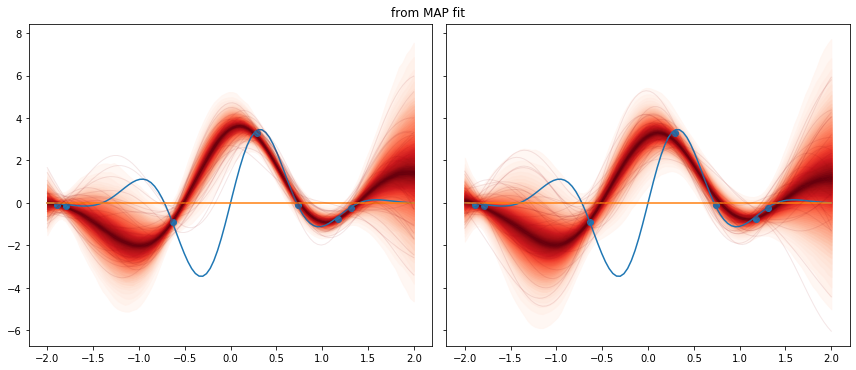

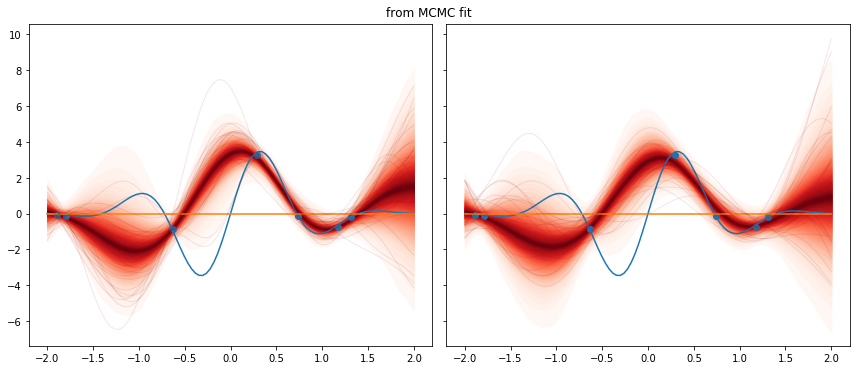

In [12]:
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:

    fig, [(left, right)] = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 5), squeeze=False, sharey='row')

    d = 0
    dname = f'D{d}'

    # plot functions
    for fname, f in [
            ('truth', truth),
            ('GP mean function', lambda x: gp.mean_func(x).eval())
        ]:
        left.plot(x_dense[:,d], f(x_dense), label=fname)
        right.plot(x_dense[:,d], f(x_dense), label=fname)

    # plot conditionals and approximations
    pymc3.gp.util.plot_gp_dist(left, pp[dname], x_dense[:,d])
    pymc3.gp.util.plot_gp_dist(right, numpy.array([
        f_rff(x_dense)
        for f_rff in rffs
    ]), x_dense[:,d])

    if D == 1:
        left.scatter(X[:,d], Y, label='$Y_{obs}$')
        right.scatter(X[:,d], Y, label='$Y_{obs}$')

    axs[0,0].set_title('conditionals')
    axs[0,1].set_title('RFF approximations')
    fig.suptitle(f'from {label} fit', y=1.02)
    fig.tight_layout()
    pyplot.show()

### Run minimization on the RFF approximations to obtain $p(x_*|X,Y)$ samples

In [13]:
x_star = {}
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:
    
    print(f'Minimizing RFFs obtained from {label} fit')

    # collect minima for all RFF functions
    x_star_x = []
    x_star_y = []
    for f_rff in fastprogress.progress_bar(rffs):
        x_best, y_best = pyrff.multi_start_fmin(
            fun=f_rff,
            x0s=numpy.random.uniform(low=BOUNDS[0], high=BOUNDS[1], size=(50, D)),
        )
        x_star_x.append(x_best)
        x_star_y.append(y_best)
    x_star[label] = (numpy.array(x_star_x), numpy.array(x_star_y))

Minimizing RFFs obtained from MAP fit


Minimizing RFFs obtained from MCMC fit


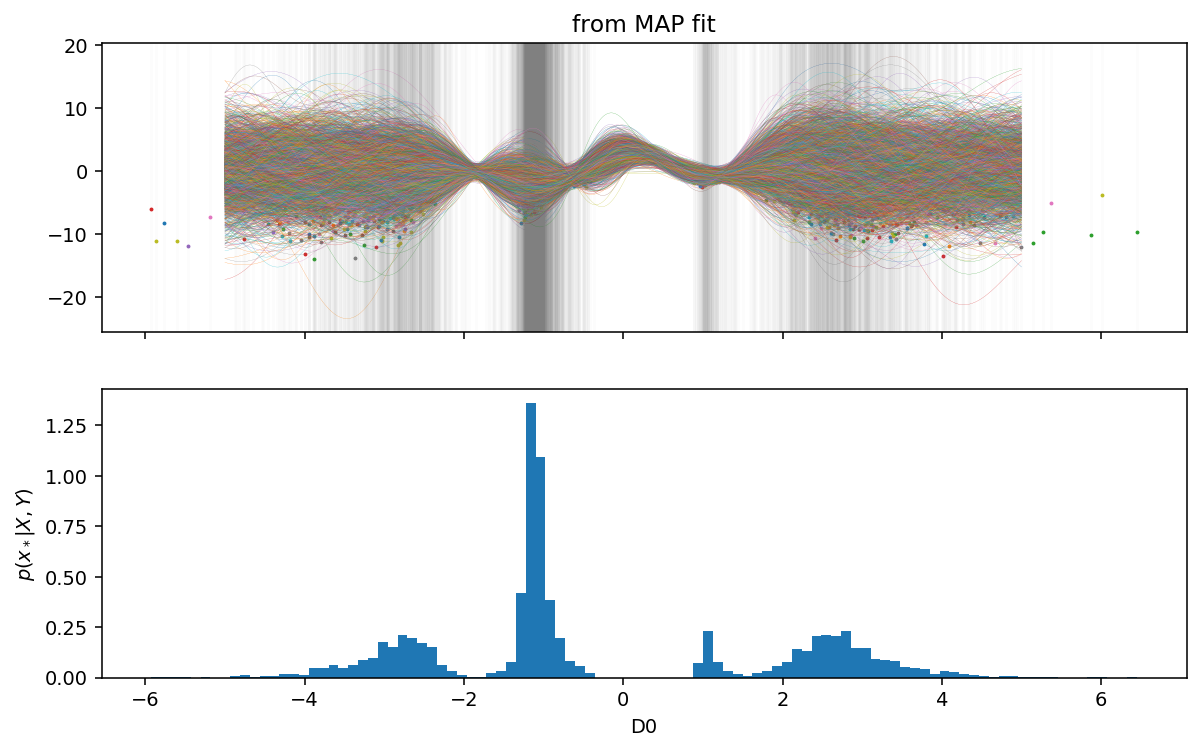

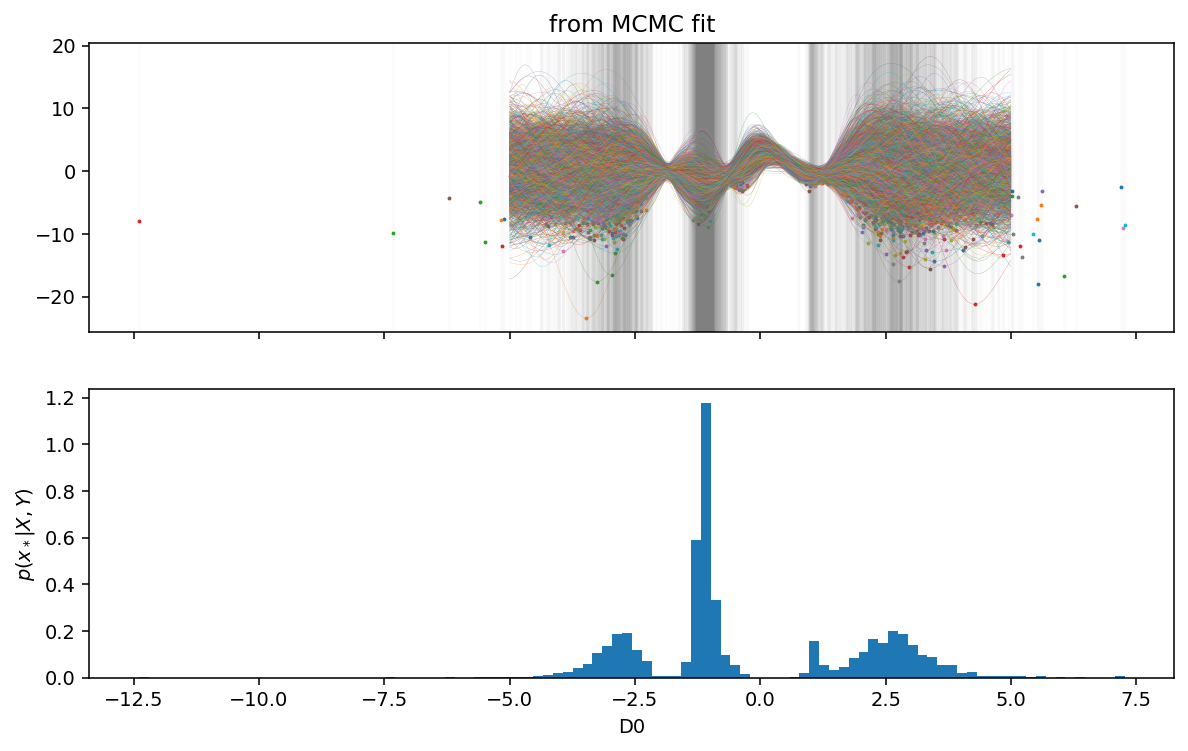

In [14]:
if D == 1:
    for l, (label, (x_star_x, x_star_y)) in enumerate(x_star.items()):
        fig, (ax, axh) = pyplot.subplots(dpi=140, nrows=2, sharex='col', figsize=(10, 6))
        x_dense = numpy.linspace(-5,5, 500)[:,numpy.newaxis]
    
        ax.set_title(f'from {label} fit')
        for f_rff, best_x, best_y in zip(rffs, x_star_x, x_star_y):
            ax.plot(
                x_dense,
                f_rff(x_dense),
                linewidth=0.1,
            )
            ax.axvline(best_x, color='grey', alpha=0.02)
            ax.scatter(
                [best_x],
                [best_y],
                s=1
            )
        axh.hist(numpy.array(x_star_x)[:,0], bins=100, density=True)
        axh.set_ylabel('$p(x_*|X,Y)$')
        axh.set_xlabel('D0')
        pyplot.show()

### Save the RFFs to a file

In [15]:
pyrff.save_rffs(rffs_map, '1D_MAP_rffs.h5')
pyrff.save_rffs(rffs_map, '1D_MCMC_rffs.h5')

'1D_MCMC_rffs.h5'